In [12]:
import javalang
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import LabelEncoder
from keras.layers import Embedding, Dense, GlobalMaxPooling1D, Input, Concatenate
from keras.models import Sequential, Model
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
dataset = pd.read_csv("../dataset/dataset_v2.csv")

def tokenize_and_normalize(source_code):
    tokens = list(javalang.tokenizer.tokenize(source_code))
    normalized_tokens = []
    for token in tokens:
        if isinstance(token, javalang.tokenizer.Identifier):
            normalized_tokens.append("IDENT")
        elif isinstance(token, javalang.tokenizer.String):
            normalized_tokens.append("STRING")
        elif isinstance(token, javalang.tokenizer.Integer):
            normalized_tokens.append("INT")
        elif isinstance(token, javalang.tokenizer.FloatingPoint):
            normalized_tokens.append("FLOAT")
        else:
            normalized_tokens.append(token.value)
    return normalized_tokens

all_tokens = []
for _, row in dataset.iterrows():
    code1 = row.iloc[0]
    code2 = row.iloc[1]
    all_tokens.extend(tokenize_and_normalize(code1))
    all_tokens.extend(tokenize_and_normalize(code2))

encoder = LabelEncoder()
encoder.fit(list(set(all_tokens)))

LabelEncoder()

In [ ]:
def tokens_to_sequence(tokens):
    return encoder.transform(tokens)

def preprocess_pair(code1, code2):
    tokens_1 = tokenize_and_normalize(code1)
    tokens_2 = tokenize_and_normalize(code2)
    seq_1 = tokens_to_sequence(tokens_1)
    seq_2 = tokens_to_sequence(tokens_2)
    return seq_1, seq_2

In [ ]:
seq_1_list, seq_2_list, labels = [], [], []
for _, row in dataset.iterrows():
    code1 = row.iloc[0]
    code2 = row.iloc[1]
    seq_1, seq_2 = preprocess_pair(code1, code2)
    seq_1_list.append(seq_1)
    seq_2_list.append(seq_2)
    labels.append(row.iloc[2])

max_len = max(max(len(s) for s in seq_1_list), max(len(s) for s in seq_2_list))
seq_1_list = pad_sequences(seq_1_list, maxlen=max_len)
seq_2_list = pad_sequences(seq_2_list, maxlen=max_len)
labels = np.array(labels)

X_train_1, X_test_1, X_train_2, X_test_2, y_train, y_test = train_test_split(
    seq_1_list, seq_2_list, labels, test_size=0.2, random_state=42
)

In [ ]:
vocab_size = len(encoder.classes_)
embedding_dim = 512

def build_encoder():
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len, mask_zero=True),
        GlobalMaxPooling1D(),
        Dense(128, activation='relu')
    ])
    return model

encoder_model = build_encoder()

input_1 = Input(shape=(max_len,))
input_2 = Input(shape=(max_len,))

encoded_1 = encoder_model(input_1)
encoded_2 = encoder_model(input_2)

merged = Concatenate()([encoded_1, encoded_2])
output = Dense(1, activation='sigmoid')(merged)

siamese_model = Model(inputs=[input_1, input_2], outputs=output)
siamese_model.compile(optimizer='adam', loss="binary_crossentropy", metrics=['accuracy'])

/home/printchard/workspace/tc3002b/Code-Plagiarism-Detection/venv/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/home/printchard/workspace/tc3002b/Code-Plagiarism-Detection/venv/lib/python3.12/site-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'global_max_pooling1d_1' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [17]:
# Train model
history = siamese_model.fit(
    [X_train_1, X_train_2], y_train,
    epochs=10,
    batch_size=16
)

Epoch 1/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 16s 221ms/step - accuracy: 0.5783 - loss: 0.6655
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 18s 255ms/step - accuracy: 0.8844 - loss: 0.3284
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 15s 220ms/step - accuracy: 0.8987 - loss: 0.2958
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 18s 259ms/step - accuracy: 0.9183 - loss: 0.2460
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 15s 215ms/step - accuracy: 0.9367 - loss: 0.2110
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 17s 250ms/step - accuracy: 0.9397 - loss: 0.1997
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 15s 215ms/step - accuracy: 0.9385 - loss: 0.1855
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 18s 254ms/step - accuracy: 0.9374 - loss: 0.1866
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 15s 220ms/step - accuracy: 0.9483 - loss: 0.1684
Epoch 10/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 18s 251ms/step - accuracy: 0.9382 - loss: 0.1586


In [18]:
# Evaluate on test set
test_similarity = siamese_model.predict([X_test_1, X_test_2])

# Example threshold evaluation
threshold = 0.5
pred_labels = (test_similarity.flatten() > threshold).astype(int)
accuracy = np.mean(pred_labels == y_test)
print(f"Test set accuracy (threshold={threshold}): {accuracy:.4f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step
Test set accuracy (threshold=0.5): 0.9101


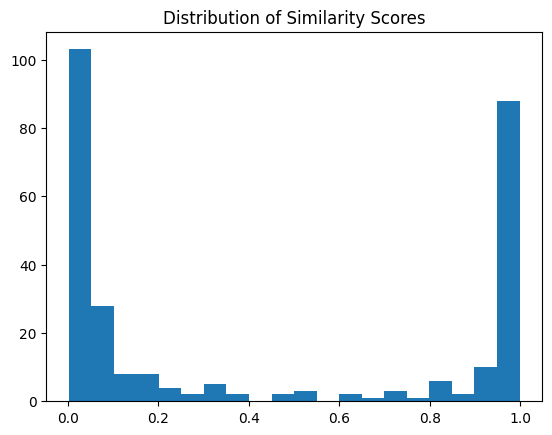

In [19]:
plt.hist(test_similarity.flatten(), bins=20)
plt.title("Distribution of Similarity Scores")
plt.show()

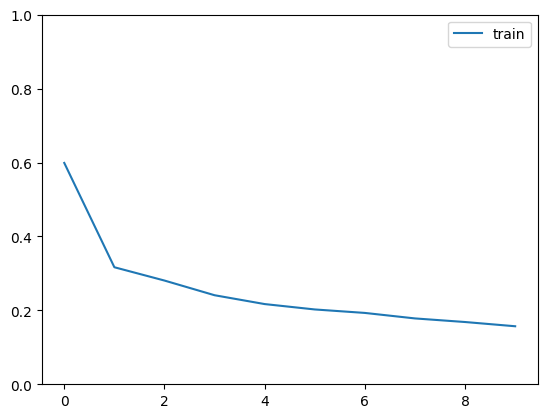

In [21]:
plt.plot(history.history['loss'], label='train')
plt.ylim((0, 1))
plt.legend()
plt.show()

In [22]:
siamese_model.save_weights("siamese_model.weights.h5")